# Importing libraries

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os

# Importing Image Directory

In [101]:
training_images=os.listdir('/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Jennifer Lawrence/')

# Creating image set and appending into the list

In [103]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


create_train_set = []
for i in training_images:
    img_path = f'../input/pins-face-recognition/105_classes_pins_dataset/pins_Jennifer Lawrence/{i}'
    img = load_img(img_path,target_size=(64,64))  # this returns a PIL image
    img = img_to_array(img)  # convert to numpy
    img = img / 255.0
    create_train_set.append(img)

training_set=np.array(create_train_set)  

In [104]:
x_test=training_set
# x_test=x_data[int(len(x_data)*0.8):]
# training_set=x_data[:int(len(x_data)*0.8)]

In [106]:
x_test.shape

(180, 64, 64, 3)

# Function to show image

In [107]:
def show_img(dataset):
    fig, ax = plt.subplots(1,4)
    fig.set_size_inches(40, 20)
    for i in range(4,8):
        ax[i-4].imshow(dataset[i].reshape(64,64,3))
    plt.show()

# Visualzing the orginal image

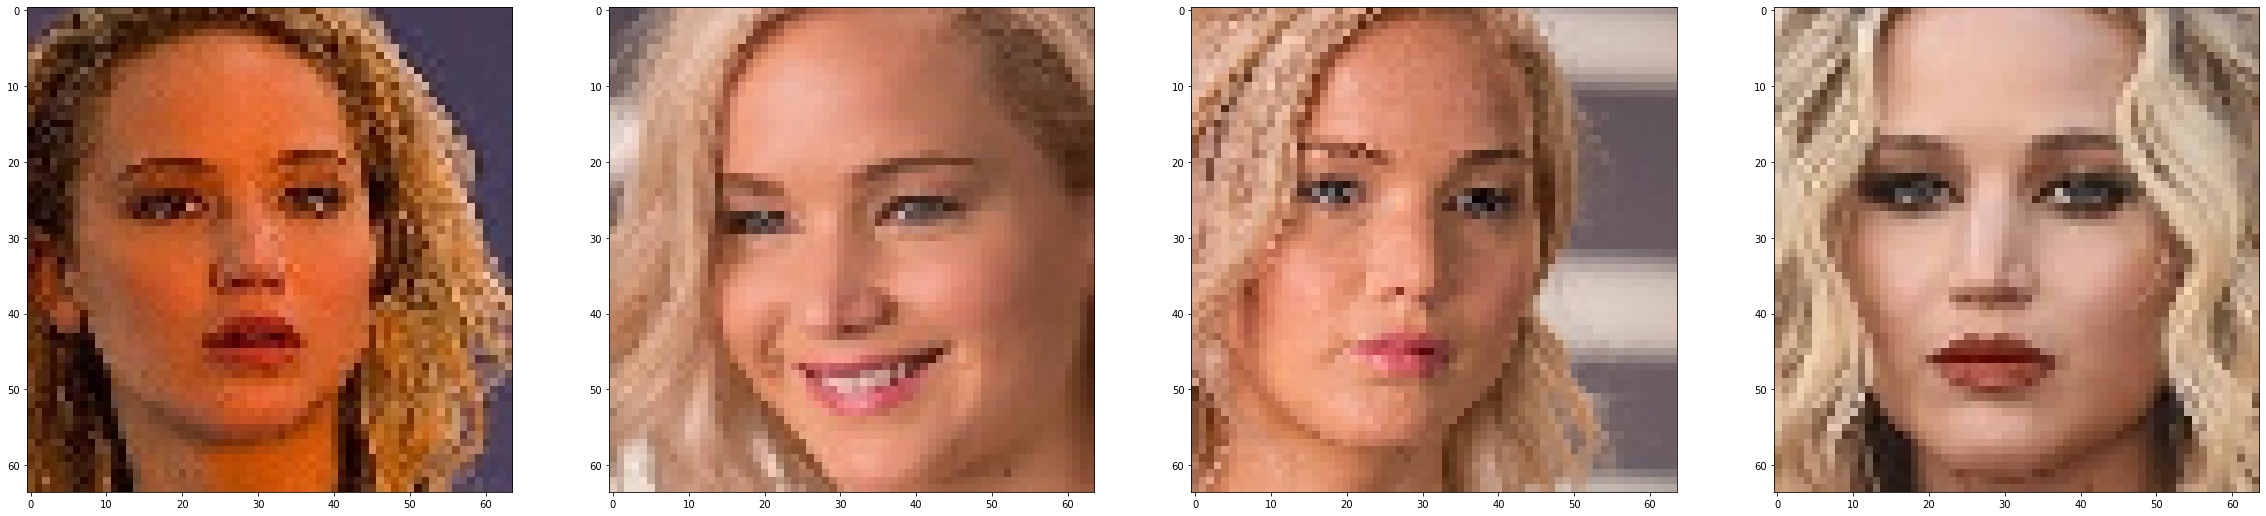

In [108]:
show_img(training_set)

In [109]:
training_set.shape

(180, 64, 64, 3)

# Function to add guassian noise/Corrupting image pixels

In [110]:
def gnoise(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.5
    return noisy

In [111]:
gnoise_set=[]
for i in training_set:
    noise=gnoise(i)
    gnoise_set.append(noise)

In [112]:
gnoise_dataset=np.array(gnoise_set)

# Visualizing the corrupted image

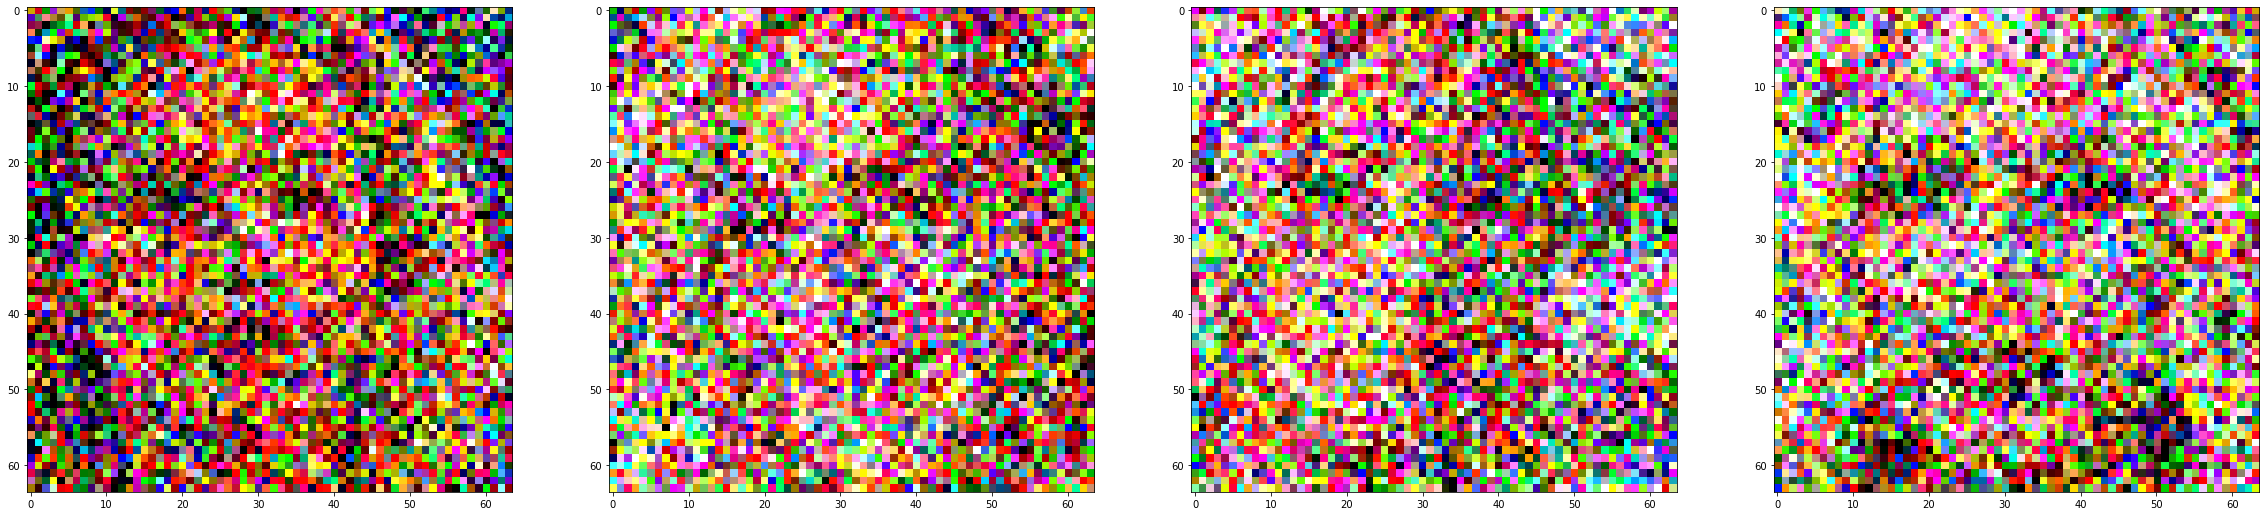

In [113]:
show_img(gnoise_dataset)


# Splitting noisy images into train and test data


In [114]:
xtrainnoisy=gnoise_dataset[0:100]
xtestnoisy=gnoise_dataset[100:]
xtestnoisy.shape

(80, 64, 64, 3)

# Training the Autoencoder

In [115]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Input

def autoencoder():
    
    input_img = Input(shape=(64,64,3), name='input_image')
    
 #enoder 
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(514, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(3, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [116]:
model= autoencoder()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 64, 512)       14336     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 512)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 512)       2359808   
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 512)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 512)       2359808   
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 32, 32, 512)       0   

In [117]:
model.fit(xtrainnoisy, xtrainnoisy, epochs=100, batch_size=10, validation_data=(xtestnoisy, xtestnoisy))

Epoch 1/100
10/10 [==============================] - 1s 60ms/step - loss: 0.3815 - val_loss: 0.2932
Epoch 2/100
10/10 [==============================] - 0s 44ms/step - loss: 0.2880 - val_loss: 0.2718
Epoch 3/100
10/10 [==============================] - 0s 45ms/step - loss: 0.2708 - val_loss: 0.2681
Epoch 4/100
10/10 [==============================] - 0s 44ms/step - loss: 0.2657 - val_loss: 0.2640
Epoch 5/100
10/10 [==============================] - 0s 44ms/step - loss: 0.2619 - val_loss: 0.2601
Epoch 6/100
10/10 [==============================] - 0s 45ms/step - loss: 0.2593 - val_loss: 0.2584
Epoch 7/100
10/10 [==============================] - 0s 44ms/step - loss: 0.2577 - val_loss: 0.2570
Epoch 8/100
10/10 [==============================] - 0s 44ms/step - loss: 0.2562 - val_loss: 0.2559
Epoch 9/100
10/10 [==============================] - 0s 44ms/step - loss: 0.2548 - val_loss: 0.2540
Epoch 10/100
10/10 [==============================] - 0s 44ms/step - loss: 0.2536 - val_loss: 0.2519

# Predictions

In [118]:
denoised_imgs = model.predict(xtrainnoisy[0:7])

In [119]:
import cv2

def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(3, 5)
    f.set_size_inches(11.5,9.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(training_set[i], (64,64,3)), aspect='auto')
        ax[1][i].imshow(np.reshape(gnoise_dataset[i], (64,64,3)), aspect='auto')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64,3)), aspect='auto')

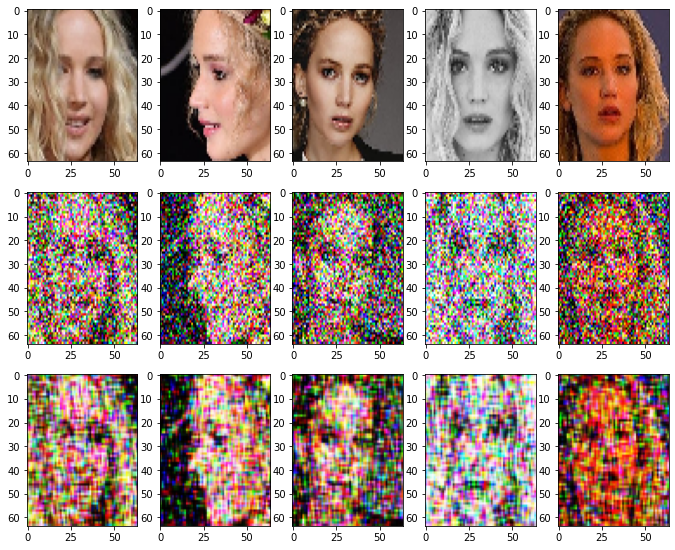

In [120]:
plot_predictions(xtestnoisy[0:7], denoised_imgs[0:7])

# Comparing original, noisy and the predicted image, it is apparent that a huge amount of noise has been removed in the predicted image. Hence our model has learnt important features of the image and has constructed the orginal image from the noisy image by removing the noise